In [1]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
from audioDataset import AudioDataset
from utils import *
from scipy.io import wavfile
import os
from scipy.signal import stft, istft, check_NOLA # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
from dimensionalityReduction import decomposeAudioSKLearn, decomposeAudio

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm # Progress bar for training

import matplotlib.pyplot as plt


In [14]:
audioDataset = AudioDataset('nsynth-valid', instruments=['keyboard', 'string', 'brass'], kwargs={'nsynth_getAcousticOnly':True})
# audioDataset.normalizeAudioData_()
data = audioDataset.getAudioData()
print(data.keys())
print([len(val) for val in data.values()])

# TODO: When deleting redundant audio data with all NSynth acoustic instruments, the last 3 instruments get completely removed. This may be a bug
audioDataset.deleteRedundantAudioData(pitchInterval=1, writeDebugFiles=False)
data = audioDataset.getAudioData() # data is all float32, but seems the same range
print(data.keys())
print([len(val) for val in data.values()])

audioDataset.setSpectrogramKwargs({'window': 'hann', 'nperseg':1024, 'noverlap':256})
print(audioDataset.getSpectrogramKwargs())

audioDataset.createSpectrogramsIndependent(deleteAudioData=False)

# audioDataset.displayInstrumentSpectrograms()
audioDataset.writeBasisFunctionAudioFiles()

uniqueShapes = set()

for instData in audioDataset.getSpectrograms().values():
    
    for sample in instData:
        uniqueShapes.add(tuple(sample.shape))

print(uniqueShapes)

dict_keys(['brass', 'keyboard', 'string'])
[886, 321, 814]
dict_keys(['brass', 'keyboard', 'string'])
[156, 65, 154]
{'window': 'hann', 'nperseg': 1024, 'noverlap': 256}
{(513, 85)}


### Define model architecture

In [157]:
class NAEModel(nn.Module):
    def __init__(self):
        super(NAEModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, padding=1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class LinearAutoencoder(nn.Module):
    def __init__(self, dataShape, R):
        super(LinearAutoencoder, self).__init__()
        self.R = R
        
        self.DIMS, self.SAMPLES = dataShape
        
        self.flattenSize = self.DIMS * self.SAMPLES
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattenSize, self.R*self.DIMS, bias=False),
            nn.Softplus(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.R*self.DIMS, self.flattenSize, bias=False),
            nn.Softplus(),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = x.view(-1, self.flattenSize)  # Flatten
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, self.DIMS, self.SAMPLES)  # Reshape back to original shape
        return x
    
    
    
class Custom2DLinear2(nn.Module):
    def __init__(self, rows, cols, weight=None):
        super(Custom2DLinear2, self).__init__()
        # Initialize weight with appropriate dimensions
        if weight is not None:
            self.weight = weight
        else:
            self.weight = nn.Parameter(torch.randn(rows, cols))

    def forward(self, x):
        # Perform matrix multiplication
        return torch.matmul(self.weight, x)
    
    
class LinearAutoencoder2D(nn.Module):
    def __init__(self, dataShape, R):
        super(LinearAutoencoder2D, self).__init__()
        self.R = R
        self.DIMS, self.SAMPLES = dataShape
        
        # Encoder
        self.encoder = nn.Sequential(
            Custom2DLinear2(rows=self.R, cols=self.DIMS),
            nn.Softplus(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            Custom2DLinear2(rows=self.DIMS, cols=self.R),
            nn.Softplus(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class ActivationNetwork(nn.Module):
    
    """
    Give the basis functions as inputs, and let the model learn the activations as "weights"
    """
    def __init__(self, dataShape, R):
        super(ActivationNetwork, self).__init__()
        self.R = R
        self.DIMS, self.SAMPLES = dataShape
        
        # Decoder
        self.decoder = nn.Sequential(
            Custom2DLinear2(rows=self.SAMPLES, cols=self.R),
            nn.Softplus(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


    
def getLoss(X, X_hat, decoder, regularizationWeight=1e-5):
    eps = 1e-10

    # L1Regularization = 1e-5 * torch.norm([p for p in modelParameters][-2], p=1)
    L1Regularization = regularizationWeight * torch.norm(decoder[0].weight.data, p=1)


    loss = torch.sum(X * (torch.log(X+eps) - torch.log(X_hat+eps)) - X + X_hat) + L1Regularization
    # loss = torch.sum((X - X_hat)**2) + L1Regularization
    return loss


def normalize(tensor, mean, std):
    return (tensor - mean) / std
    
def log_normalize(tensor, _, _2):
    epsilon = 1e-7  # to prevent log(0)
    tensor = torch.log(tensor + epsilon)
    return tensor
    

# Normalization function
def minMaxNormalize(tensor, minVal, maxVal):
    return (tensor - minVal) / (maxVal - minVal)

def minMaxDenormalize(tensor, minVal, maxVal):
    return tensor * (maxVal - minVal) + minVal


### Create dataset which is a single spectrogram to decompose

1
Data shape: torch.Size([513, 117])


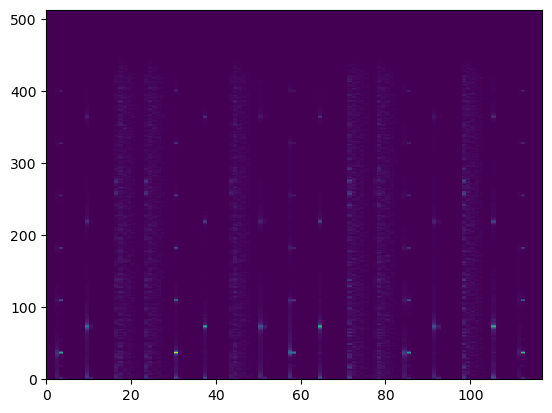

In [158]:
# Apply this normalization to training and testing data

    
# Example data lists (replace these with your actual data tensors)
# brass_data = [torch.randn(513, 85) for _ in range(100)]  # Replace with your brass spectrograms
# strings_data = [torch.randn(513, 85) for _ in range(100)]  # Replace with your strings spectrograms
# keyboard_data = [torch.randn(513, 85) for _ in range(100)]  # Replace with your keyboard spectrograms

# Concatenate data into a single dataset
all_data = []


fs, rawWav = wavfile.read('vl1.wav') # read as int16
mag = audioDataset.getMagnitudeSpectrogram(rawWav, fs)
all_data = [torch.from_numpy(mag.astype(np.float32))]

# all_data = [torch.from_numpy(sample) for sample in audioDataset.getSpectrograms()['keyboard']]
print(len(all_data))
spectrogramTensor = torch.stack(all_data)

dataShape = spectrogramTensor[0].size()
print(f'Data shape: {dataShape}')

# for idx in range(all_data_tensor.size()[0]):
#     x = all_data_tensor[idx]
#     plt.pcolormesh(x), plt.show()
#     y = x.view(-1, dataShape[0]*dataShape[1])  # Flatten
#     displayX = y.view(dataShape[0], dataShape[1])
#     plt.pcolormesh(displayX), plt.show()

plt.pcolormesh(spectrogramTensor.squeeze()), plt.show()

# Create TensorDataset
dataset = TensorDataset(spectrogramTensor)

# Create DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

### Train model to learn weights matrix W (basis functions)

torch.Size([3, 513])
torch.Size([513, 3])


lr: 0.0000000153, trainLoss: 57.53: 100%|██████████| 200/200 [00:00<00:00, 248.80it/s]  


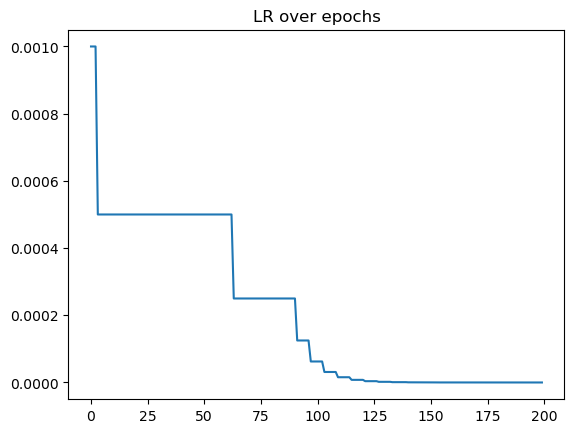

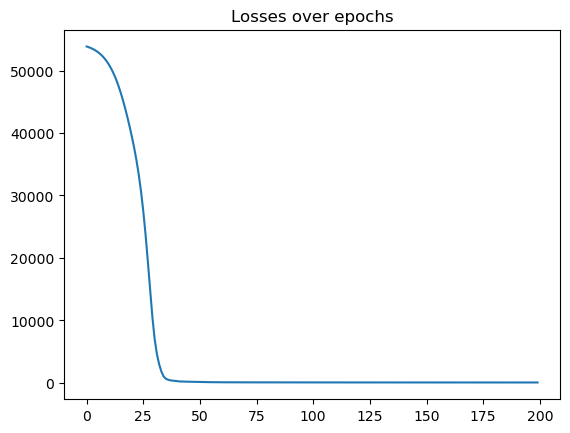

[torch.Size([3, 513]), torch.Size([513, 3])]


In [159]:
basisModel = LinearAutoencoder2D(R=3, dataShape=dataShape)
for p in basisModel.parameters():
    print(p.size())


# Compute min and max from the training data
minSpec = spectrogramTensor.min()
maxSpec = spectrogramTensor.max()

# Put everything on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basisModel = basisModel.to(device)

# Define optimizer and LR scheduler
optimizer = torch.optim.Rprop(basisModel.parameters(), lr=1e-3)
plateuScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=1e-2, cooldown=4)

# Lists to store values for plotting later
losses = []
lrs = []
weightsList = []

# How many epochs, nothing too large or the L1 regularization takes over and we don't properly fit the basis functions
epochs = 200

pbar = tqdm(range(0, epochs))
for epoch in pbar:
    basisModel.train()
    epochLoss = 0
    for batch_idx, (data,) in enumerate(loader):
        data = minMaxNormalize(data, minSpec, maxSpec).to(device)
        # data = data.to(device)

        # Delete old gradients
        optimizer.zero_grad()
        # Do forward pass
        reconstruction = basisModel(data)
        # print(reconstruction.size())
        
        # Get loss and update weights with gradient clipping to prevent exploding gradients
        loss = getLoss(data, reconstruction, decoder=basisModel.decoder, regularizationWeight=1e-3)
        loss.backward()
        torch.nn.utils.clip_grad_value_(basisModel.parameters(), clip_value=1) # Clip gradients after calculating loss
        optimizer.step()

        epochLoss += loss.item()
        
    # Store data for plotting
    lastLr = plateuScheduler.optimizer.param_groups[0]['lr']
    lastLoss = epochLoss/len(loader)
    lrs.append(lastLr)
    losses.append(lastLoss)
    learnedBasisFunctions = basisModel.decoder[0].weight.data
    basis_functions_reshaped = [learnedBasisFunctions]

    # Save currently learned basis functions for plotting
    # unNormalizedBases = minMaxDenormalize(learnedBasisFunctions, minSpec, maxSpec).detach().cpu().numpy()
    unNormalizedBases = learnedBasisFunctions.detach().cpu().numpy()

    weightsList.append(unNormalizedBases)
    
    # Set progress bar description
    pbar.set_description("lr: {:.10f}, trainLoss: {:.2f}".format(lastLr, lastLoss), refresh=True)
    
    # Update LR if needed
    plateuScheduler.step(lastLoss)

    # print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(loader)}')

plt.plot(lrs), plt.title('LR over epochs'), plt.show()
plt.plot(losses), plt.title('Losses over epochs'), plt.show()

print([p.size() for p in basisModel.parameters()])


### Visualize learned basis functions, non negativity not guaranteed

Basis functions size: torch.Size([513, 3])


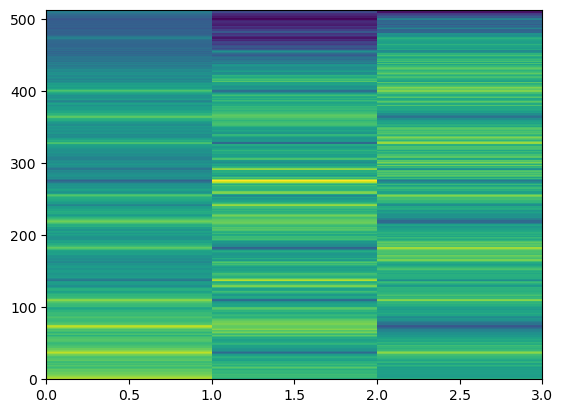

(<matplotlib.collections.QuadMesh at 0x27113038c70>, None)

In [160]:
learnedBasisFunctions = basisModel.decoder[0].weight.data
print(f'Basis functions size: {learnedBasisFunctions.size()}')

# unNormalizedBases = minMaxDenormalize(learnedBasisFunctions, minSpec, maxSpec)
unNormalizedBases = learnedBasisFunctions

# print(len(unNormalizedBases))

sample = unNormalizedBases.cpu().numpy()
plt.pcolormesh(sample), plt.show()
    
    
# Prints basis functions as they are learned
# for i, img in enumerate(weightsList[:100]):
#     if i % 10 == 0:
#         for j in range(3):
#             plt.plot(img[0][:, j])
#         plt.show()


### Create dataset to hold learned basis functions

Data shape: torch.Size([3, 513])


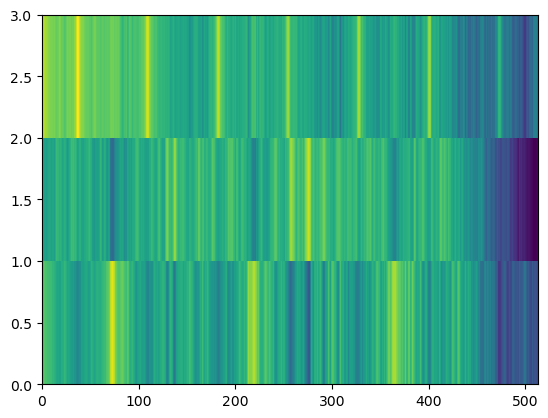

In [142]:
basisDataTensor = torch.stack([learnedBasisFunctions.T])

dataShape = basisDataTensor[0].size()
print(f'Data shape: {dataShape}')

# Create TensorDataset
dataset = TensorDataset(basisDataTensor)

plt.pcolormesh(basisDataTensor.cpu().squeeze()), plt.show()


# Create DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Compute min and max from the training data
minBasis = basisDataTensor.min()
maxBasis = basisDataTensor.max()

### Create new single layer model that will learn activations given basis functions and original data

torch.Size([117, 3])


lr: 0.0005000000, trainLoss: 1373730.00: 100%|██████████| 200/200 [00:00<00:00, 403.51it/s]


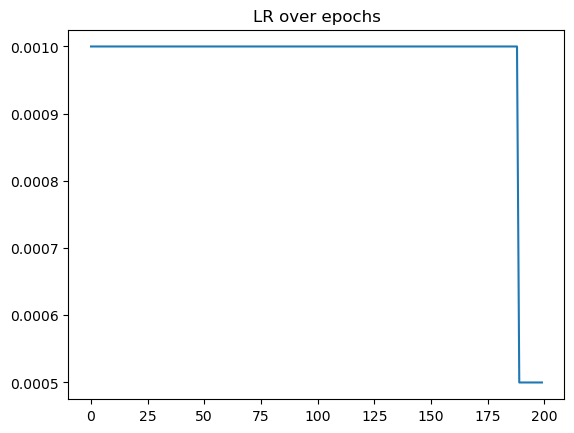

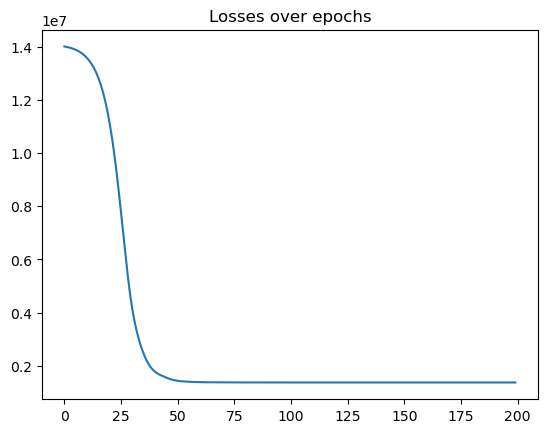

[torch.Size([117, 3])]


In [143]:
activationModel = ActivationNetwork(R=3, dataShape=(basisModel.DIMS, basisModel.SAMPLES))
for p in activationModel.parameters():
    print(p.size())




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
activationModel = activationModel.to(device)

# Optimizer (replace with your choice of optimizer and parameters)
optimizer = torch.optim.Rprop(activationModel.parameters(), lr=1e-3)
plateuScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=1e-3, cooldown=4)

losses = []
lrs = []

weightsList = []

# Training Loop
epochs = 200  # Set the number of epochs

# normalizedSpectrogram = minMaxNormalize(spectrogramTensor.T, minSpec, maxSpec).to(device)
normalizedSpectrogram = spectrogramTensor.T.to(device)

# spectrogramTensor is shape (1, DIMS, SAMPLES) and we need to transpose it to be (1, SAMPLES, DIMS), so we do this to move the singleton dimension
normalizedSpectrogram = normalizedSpectrogram.squeeze().unsqueeze(0)

pbar = tqdm(range(0, epochs))
for epoch in pbar:
    activationModel.train()
    epochLoss = 0
    for batch_idx, (data,) in enumerate(loader):
        # data = minMaxNormalize(data, minBasis, maxBasis).to(device)
        data = data.to(device)

        optimizer.zero_grad()
        reconstruction = activationModel(data)
        # print(reconstruction.size())
        loss = getLoss(X=normalizedSpectrogram, X_hat=reconstruction, decoder=activationModel.decoder, regularizationWeight=1e-3)
        loss.backward()
        torch.nn.utils.clip_grad_value_(activationModel.parameters(), clip_value=1) # Clip gradients after calculating loss
        optimizer.step()

        epochLoss += loss.item()
        
    lastLr = plateuScheduler.optimizer.param_groups[0]['lr']
    lastLoss = epochLoss/len(loader)
    
    lrs.append(lastLr)
    losses.append(lastLoss)
    
    learnedActivations = activationModel.decoder[0].weight.data

    # unNormalizedActivations = minMaxDenormalize(learnedActivations, minBasis, maxBasis).detach().cpu().numpy()
    unNormalizedActivations = learnedActivations.detach().cpu().numpy()

    weightsList.append(unNormalizedActivations)
    
    pbar.set_description("lr: {:.10f}, trainLoss: {:.2f}".format(lastLr, lastLoss), refresh=True)
        
    plateuScheduler.step(lastLoss)

    # print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(loader)}')

plt.plot(lrs), plt.title('LR over epochs'), plt.show()
plt.plot(losses), plt.title('Losses over epochs'), plt.show()

print([p.size() for p in activationModel.parameters()])


Basis functions size: torch.Size([3, 117])


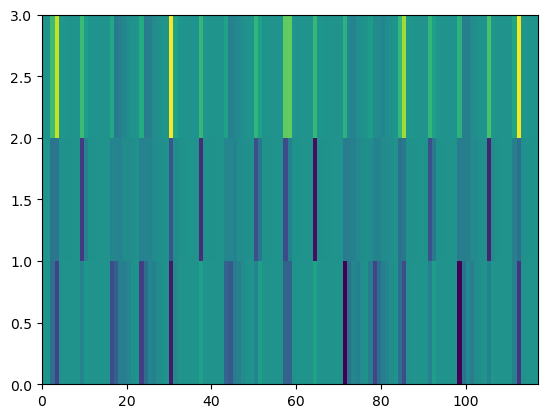

(<matplotlib.collections.QuadMesh at 0x2710f3d0460>, None)

In [144]:
learnedActivations = activationModel.decoder[0].weight.data.T
print(f'Basis functions size: {learnedActivations.size()}')

# unNormalizedActivations = minMaxDenormalize(learnedActivations, minSpec, maxSpec)
unNormalizedActivations = learnedActivations

sample = unNormalizedActivations.cpu().numpy()
plt.pcolormesh(sample), plt.show()

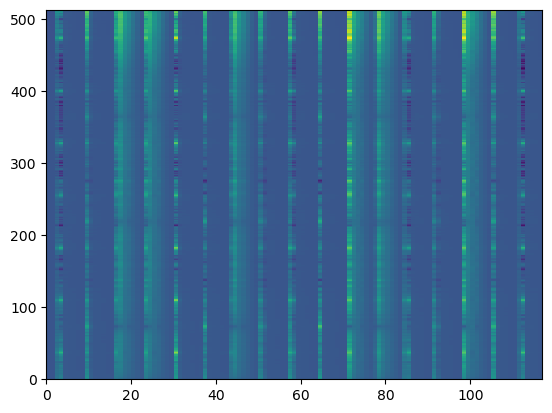

(<matplotlib.collections.QuadMesh at 0x27110167e20>, None)

In [145]:
plt.pcolormesh(unNormalizedBases.cpu().numpy() @ unNormalizedActivations.cpu().numpy()), plt.show()